Original dataset shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Cleaned dataset shape: (805620, 9)


,CustomerID,Recency,Frequency,Monetary,AOV,LTV
0,12346.0,325,12,77556.46,6463.038333,77556.46
1,12347.0,1,8,5633.32,704.165000,5633.32
2,12348.0,74,5,2019.40,403.880000,2019.40
3,12349.0,18,4,4428.69,1107.172500,4428.69
4,12350.0,309,1,334.40,334.400000,334.40


C:\Users\santh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


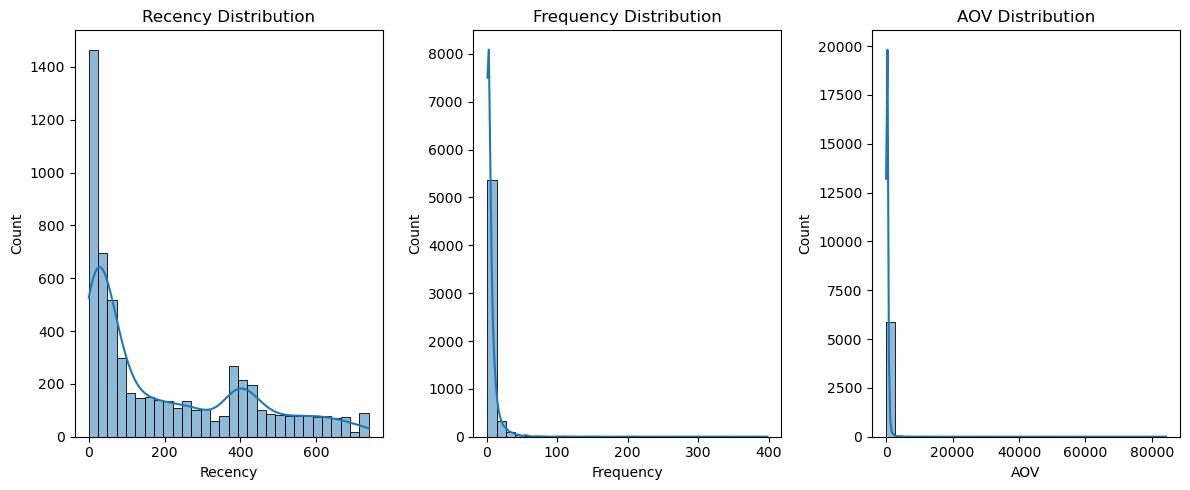

Saved: output/feature_distributions.png
Model saved to models/ltv_xgboost_model.pkl
MAE: 365.67
RMSE: 6576.05


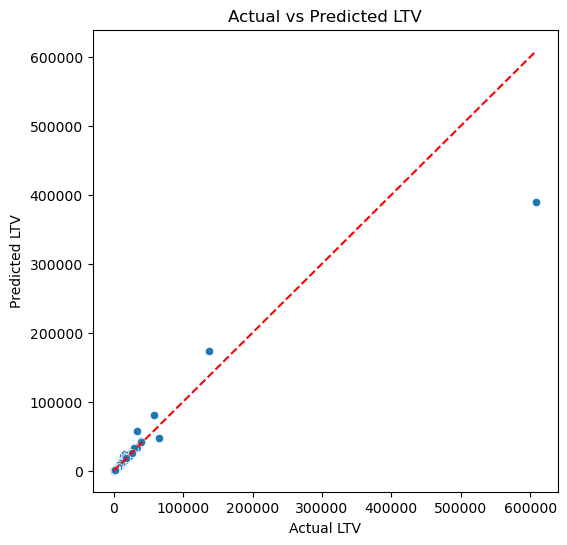

Saved: output/actual_vs_predicted.png


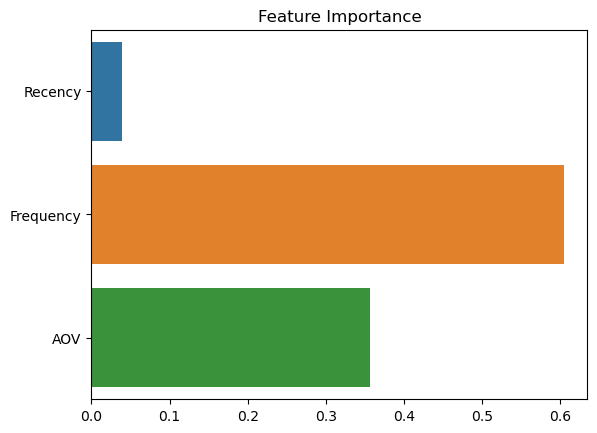

Saved: output/feature_importance.png
Predictions saved to output/ltv_predictions.csv


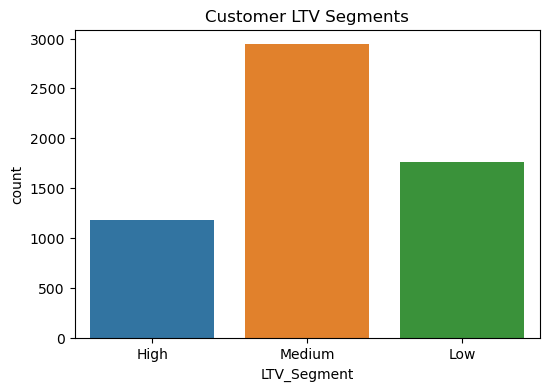

Saved: output/ltv_segments_distribution.png


In [1]:
# Customer Lifetime Value (LTV) Prediction Model
# Dataset: online_retail_II.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import joblib

# Ensure output directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 1️⃣ Load the dataset
df = pd.read_csv('online_retail_II.csv', encoding='unicode_escape')

print(f"Original dataset shape: {df.shape}")
display(df.head())

# 2️⃣ Data Cleaning
df = df[df['Customer ID'].notnull()]
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['TotalPrice'] = df['Quantity'] * df['Price']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Cleaned dataset shape: {df.shape}")

# 3️⃣ Feature Engineering
reference_date = df['InvoiceDate'].max()

customer_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']
customer_df['LTV'] = customer_df['Monetary']

display(customer_df.head())

# 4️⃣ Visualize feature distributions
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.histplot(customer_df['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

plt.subplot(1,3,2)
sns.histplot(customer_df['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1,3,3)
sns.histplot(customer_df['AOV'], bins=30, kde=True)
plt.title('AOV Distribution')

plt.tight_layout()
plt.savefig('output/feature_distributions.png')
plt.show()
print("Saved: output/feature_distributions.png")

# 5️⃣ Prepare data for model
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['LTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6️⃣ Train XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'models/ltv_xgboost_model.pkl')
print("Model saved to models/ltv_xgboost_model.pkl")

# 7️⃣ Predictions and evaluation
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Actual vs predicted scatter
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual LTV')
plt.ylabel('Predicted LTV')
plt.title('Actual vs Predicted LTV')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.savefig('output/actual_vs_predicted.png')
plt.show()
print("Saved: output/actual_vs_predicted.png")

# 8️⃣ Feature importance
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importance')
plt.savefig('output/feature_importance.png')
plt.show()
print("Saved: output/feature_importance.png")

# 9️⃣ Predict LTV for all customers and segment
customer_df['Predicted_LTV'] = model.predict(X)

def segment_ltv(x):
    if x >= customer_df['Predicted_LTV'].quantile(0.8):
        return 'High'
    elif x >= customer_df['Predicted_LTV'].quantile(0.3):
        return 'Medium'
    else:
        return 'Low'

customer_df['LTV_Segment'] = customer_df['Predicted_LTV'].apply(segment_ltv)

# 10️⃣ Export results
customer_df[['CustomerID', 'Predicted_LTV', 'LTV_Segment']].to_csv('output/ltv_predictions.csv', index=False)
print("Predictions saved to output/ltv_predictions.csv")

# 11️⃣ Visualize segments
plt.figure(figsize=(6,4))
sns.countplot(x='LTV_Segment', data=customer_df, order=['High', 'Medium', 'Low'])
plt.title('Customer LTV Segments')
plt.savefig('output/ltv_segments_distribution.png')
plt.show()
print("Saved: output/ltv_segments_distribution.png")
